# Mobility Agent vs LLM

### Target distribution compared with ground truth

In [116]:
import pandas as pd

dfs = []
for num_samples in [0,50]:
    result_file = f"models/mobility_agent/mobility_agent_{num_samples}.csv"
    result_df = pd.read_csv(result_file)
    if num_samples ==0:
       result_df["model"] = ['LLM']*len(result_df)
    else:
        result_df["model"] = ['Preference Chain']*len(result_df)
    dfs.append(result_df)

df = pd.concat(dfs)
df = df[['primary_mode','duration_minutes','predicted_mode','predicted_duration','model']]
df.head()

,primary_mode,duration_minutes,predicted_mode,predicted_duration,model
0,walking,10-20,private_auto,10-20,LLM
1,walking,50-60,walking,30-40,LLM
2,biking,0-10,public_transit,40-50,LLM
3,auto_passenger,10-20,private_auto,30-40,LLM
4,walking,10-20,walking,0-10,LLM


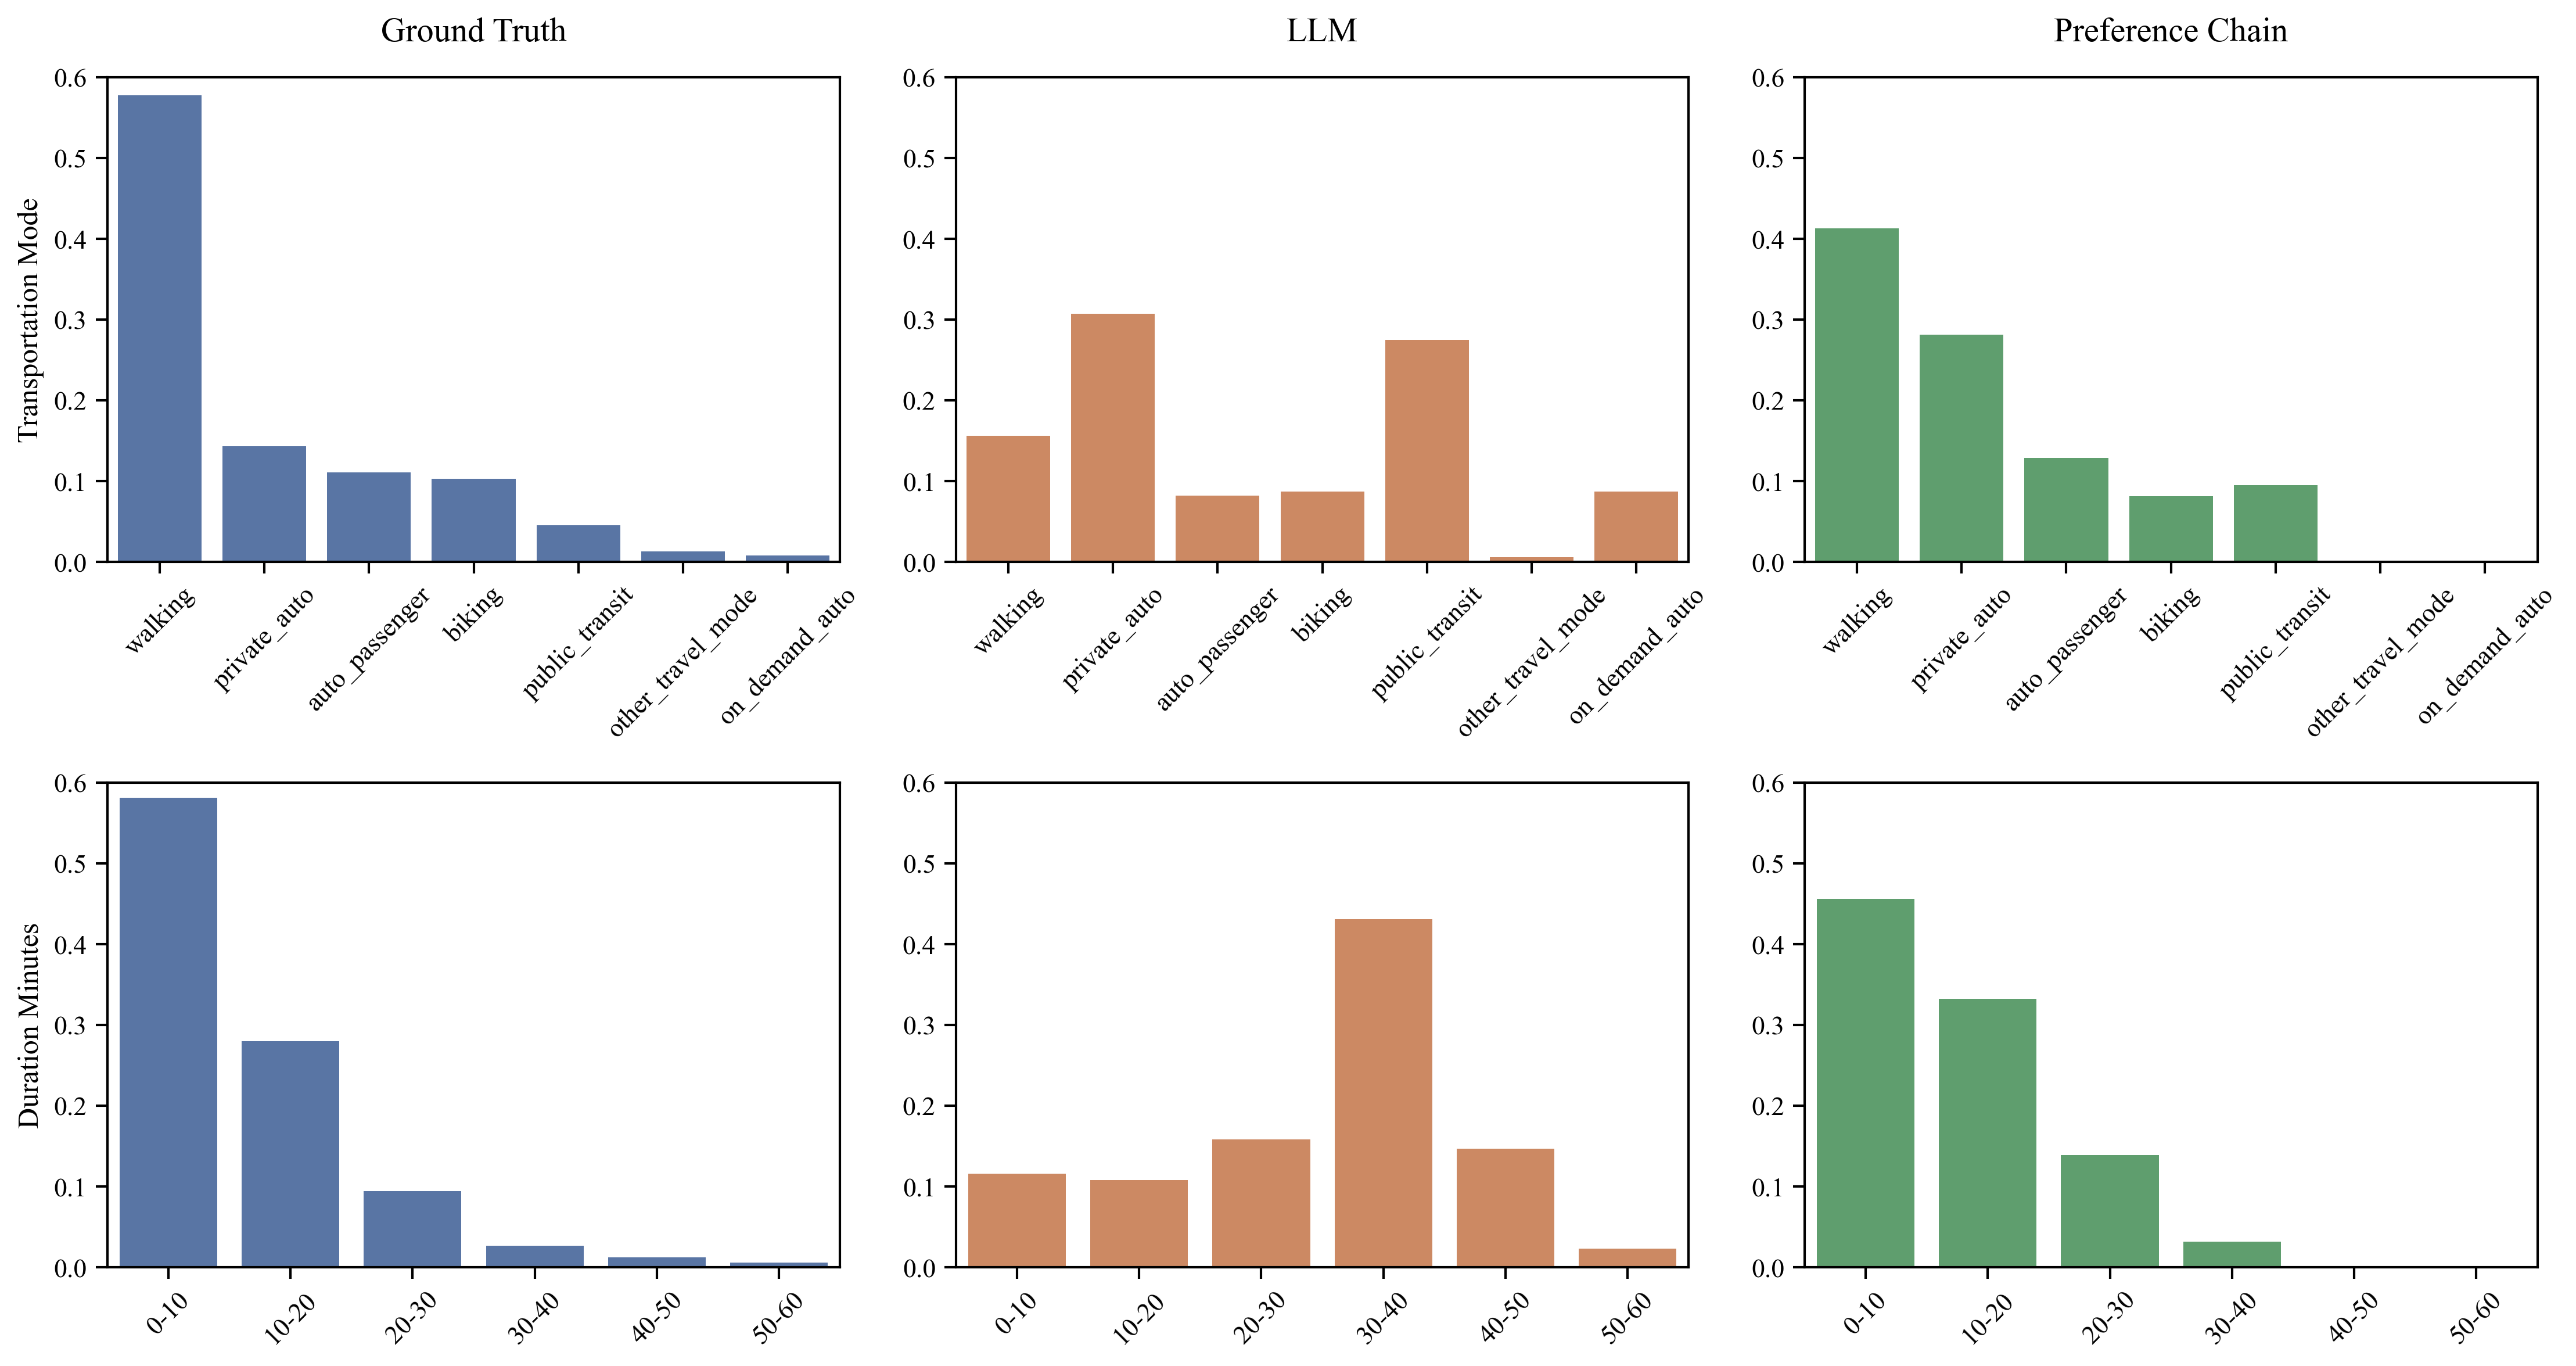

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置学术论文风格的绘图样式
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (15, 10)
})


y_max = 0.6
# 准备数据 - 将真实值和预测值统一格式
ground_truth = df[['primary_mode', 'duration_minutes']].copy()
ground_truth['type'] = 'Ground Truth'

llm_pred = df[df['model'] == 'LLM'][['predicted_mode', 'predicted_duration']].copy()
llm_pred.columns = ['mode', 'duration']
llm_pred['type'] = 'LLM'

pc_pred = df[df['model'] == 'Preference Chain'][['predicted_mode', 'predicted_duration']].copy()
pc_pred.columns = ['mode', 'duration']
pc_pred['type'] = 'Preference Chain'

# 合并所有数据
all_mode = pd.concat([
    ground_truth[['primary_mode', 'type']].rename(columns={'primary_mode': 'mode'}),
    llm_pred[['mode', 'type']],
    pc_pred[['mode', 'type']]
])

all_duration = pd.concat([
    ground_truth[['duration_minutes', 'type']].rename(columns={'duration_minutes': 'duration'}),
    llm_pred[['duration', 'type']],
    pc_pred[['duration', 'type']]
])

# 计算概率分布并按真实值排序
def calculate_probability(df, value_col, type_col, sort_order=None):
    # 计算每个类别的概率
    prob_df = (df.groupby([type_col, value_col]).size() / 
               df.groupby(type_col).size()).reset_index(name='probability')
    
    # 如果提供了排序顺序，按照该顺序排序
    if sort_order is not None:
        # 确保所有类别都在排序顺序中
        categories = pd.Categorical(prob_df[value_col], categories=sort_order, ordered=True)
        prob_df[value_col] = categories
        prob_df = prob_df.sort_values([type_col, value_col])
    
    return prob_df

# 获取真实值的排序顺序（按频率从高到低）
mode_order = ground_truth['primary_mode'].value_counts().index.tolist()
duration_order = ground_truth['duration_minutes'].value_counts().index.tolist()

# 计算模式概率
mode_prob = calculate_probability(all_mode, 'mode', 'type', mode_order)
# 计算持续时间概率
duration_prob = calculate_probability(all_duration, 'duration', 'type', duration_order)

# 创建2行3列的图形
fig, axes = plt.subplots(2, 3, figsize=(15, 8),dpi=300)

# 颜色设置
colors = ['#4C72B0', '#DD8452', '#55A868']

# 第一行：模式概率分布
# Ground Truth模式分布
gt_mode = mode_prob[mode_prob['type'] == 'Ground Truth']
sns.barplot(data=gt_mode, x='mode', y='probability', ax=axes[0, 0], color=colors[0])
axes[0, 0].set_title('Ground Truth', pad=15)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Transportation Mode')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0, y_max)

# LLM模式分布
llm_mode = mode_prob[mode_prob['type'] == 'LLM']
sns.barplot(data=llm_mode, x='mode', y='probability', ax=axes[0, 1], color=colors[1])
axes[0, 1].set_title('LLM', pad=15)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, y_max)

# Preference Chain模式分布
pc_mode = mode_prob[mode_prob['type'] == 'Preference Chain']
sns.barplot(data=pc_mode, x='mode', y='probability', ax=axes[0, 2], color=colors[2])
axes[0, 2].set_title('Preference Chain', pad=15)
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(0, y_max)

# 第二行：持续时间概率分布
# Ground Truth持续时间分布
gt_duration = duration_prob[duration_prob['type'] == 'Ground Truth']
sns.barplot(data=gt_duration, x='duration', y='probability', ax=axes[1, 0], color=colors[0])
axes[1, 0].set_title('', pad=15)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Duration Minutes')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(0, y_max)

# LLM持续时间分布
llm_duration = duration_prob[duration_prob['type'] == 'LLM']
sns.barplot(data=llm_duration, x='duration', y='probability', ax=axes[1, 1], color=colors[1])
axes[1, 1].set_title('', pad=15)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(0, y_max)

# Preference Chain持续时间分布
pc_duration = duration_prob[duration_prob['type'] == 'Preference Chain']
sns.barplot(data=pc_duration, x='duration', y='probability', ax=axes[1, 2], color=colors[2])
axes[1, 2].set_title('', pad=15)
axes[1, 2].set_xlabel('')
axes[1, 2].set_ylabel('')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_ylim(0, y_max)

# 调整布局
plt.tight_layout()

# 添加整体标题
# fig.suptitle('Comparison of Ground Truth and Model Predictions (Normalized Probability Distribution)', y=1.02)

plt.show()

### Performanc across features

In [121]:
import pandas as pd
from baseline.eval import cal_group_kl_divergence

dfs = []
for num_samples in [0,50]:
    result_file = f"models/mobility_agent/mobility_agent_{num_samples}.csv"
    result_df = pd.read_csv(result_file)
    kl_df, overall_kl,overall_mae = cal_group_kl_divergence(result_df=result_df)
    if num_samples ==0:
        kl_df["model"] = ['LLM']*len(kl_df)
    else:
        kl_df["model"] = ['Preference Chain']*len(kl_df)
    dfs.append(kl_df)


df = pd.concat(dfs)
df.head()

,feature,value,target,sample_size,kl_divergence,mae,model
0,age_group,Under 18,primary_mode,85,0.792329,0.164706,LLM
1,age_group,Under 18,duration_minutes,85,0.967852,0.192157,LLM
2,age_group,55-64,primary_mode,80,0.533744,0.135714,LLM
3,age_group,55-64,duration_minutes,80,0.999525,0.153125,LLM
4,age_group,65+,primary_mode,96,1.884244,0.136905,LLM


/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_10594/1828014556.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


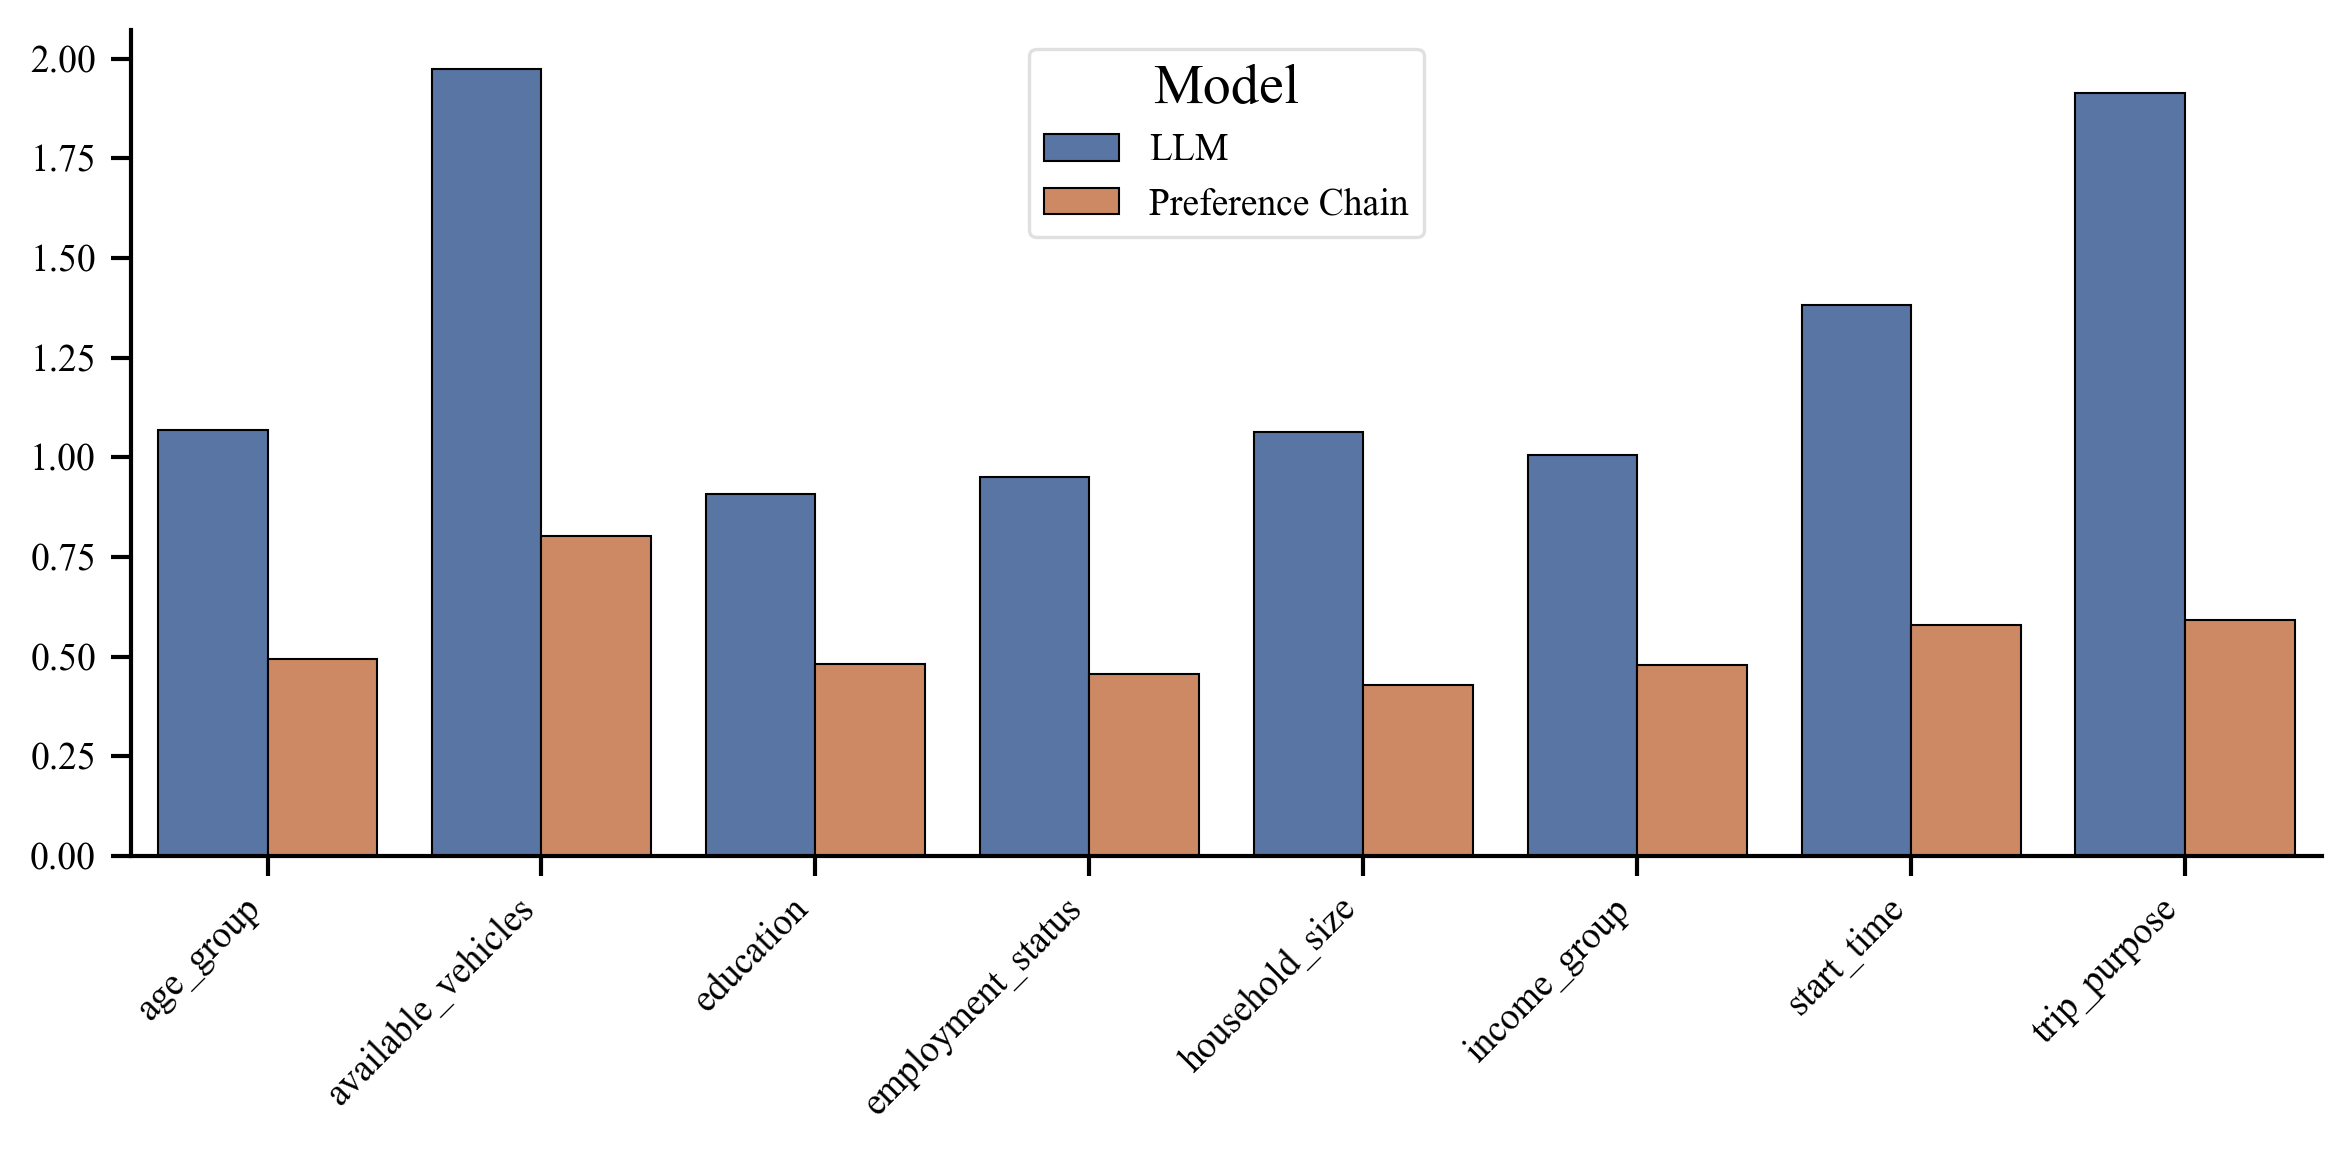

/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_10594/1828014556.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


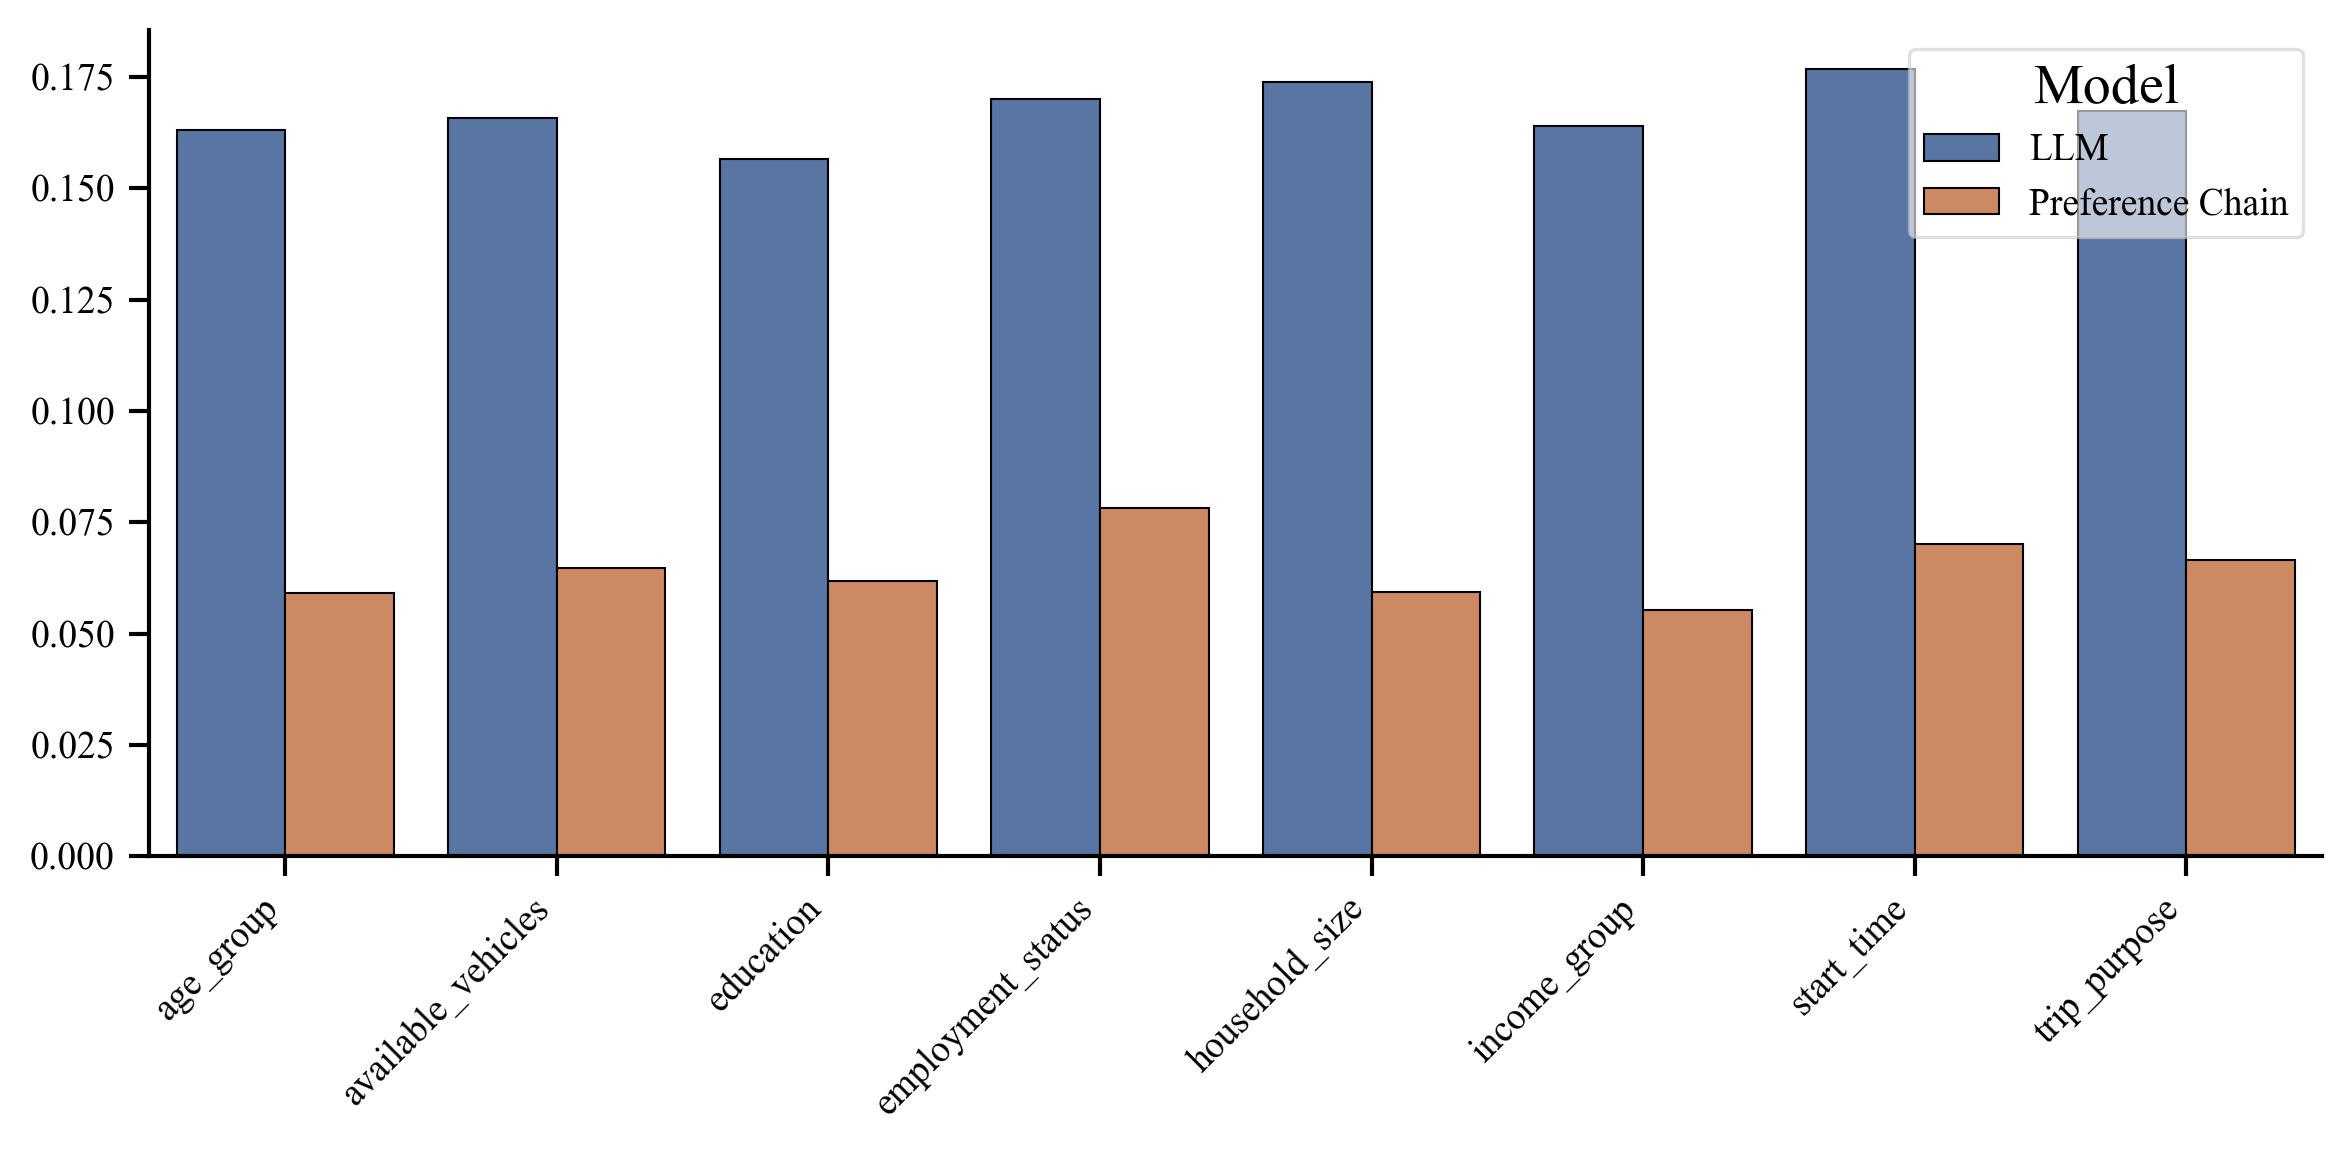

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set academic style parameters
# plt.style.use('seaborn-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,  # Set to True if you have LaTeX installed
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})

# Define color palette
palette = {"LLM": "#4C72B0", "Preference Chain": "#DD8452"}  # Blue and orange

# Define features and models
features_to_plot = [
    'age_group', 'income_group', 'employment_status',
    'household_size', 'available_vehicles', 'education',
    'trip_purpose', 'start_time'
]
models_to_compare = ['LLM', 'Preference Chain']

# Data cleaning
df.columns = df.columns.str.strip()
df_filtered = df[df['model'].isin(models_to_compare)].copy()

# Ensure numeric types
df_filtered.loc[:, 'kl_divergence'] = pd.to_numeric(df_filtered['kl_divergence'], errors='coerce')
df_filtered.loc[:, 'mae'] = pd.to_numeric(df_filtered['mae'], errors='coerce')
df_filtered = df_filtered[df_filtered['feature'].isin(features_to_plot)]

if df_filtered.empty:
    print(f"Warning: No data found for models {models_to_compare} with specified features.")
else:
    # Aggregate data
    df_agg = df_filtered.groupby(['feature', 'model'], as_index=False).agg(
        kl_divergence_mean=('kl_divergence', 'mean'),
        mae_mean=('mae', 'mean')
    )

    if df_agg.empty:
        print("Warning: No data available for plotting after aggregation.")
    else:
        # Plot 1: KL Divergence
        fig1, ax1 = plt.subplots(figsize=(8, 4))
        sns.barplot(data=df_agg, x='feature', y='kl_divergence_mean', hue='model',
                    palette=palette, ax=ax1, edgecolor='black', linewidth=0.5)
        
        # Formatting
        ax1.set_title('', pad=20)
        ax1.set_xlabel('', labelpad=10)
        ax1.set_ylabel('', labelpad=10)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        # ax1.grid(True, linestyle='--', alpha=0.3)
        ax1.legend(title='Model', frameon=True, framealpha=0.6)
        
        # Remove spines
        for spine in ['top', 'right']:
            ax1.spines[spine].set_visible(False)
        
        plt.tight_layout()
        plt.show()

        # Plot 2: MAE
        fig2, ax2 = plt.subplots(figsize=(8, 4))
        sns.barplot(data=df_agg, x='feature', y='mae_mean', hue='model',
                    palette=palette, ax=ax2, edgecolor='black', linewidth=0.5)
        
        # Formatting
        ax2.set_title('', pad=20)
        ax2.set_xlabel('', labelpad=10)
        ax2.set_ylabel('', labelpad=10)  # Replace 'units' with your actual unit
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        # ax2.grid(True, linestyle='--', alpha=0.3)
        ax2.legend(title='Model', frameon=True, framealpha=0.6)
        
        # Remove spines
        for spine in ['top', 'right']:
            ax2.spines[spine].set_visible(False)
        
        plt.tight_layout()
        plt.show()

/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_10594/2903118150.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_10594/2903118150.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


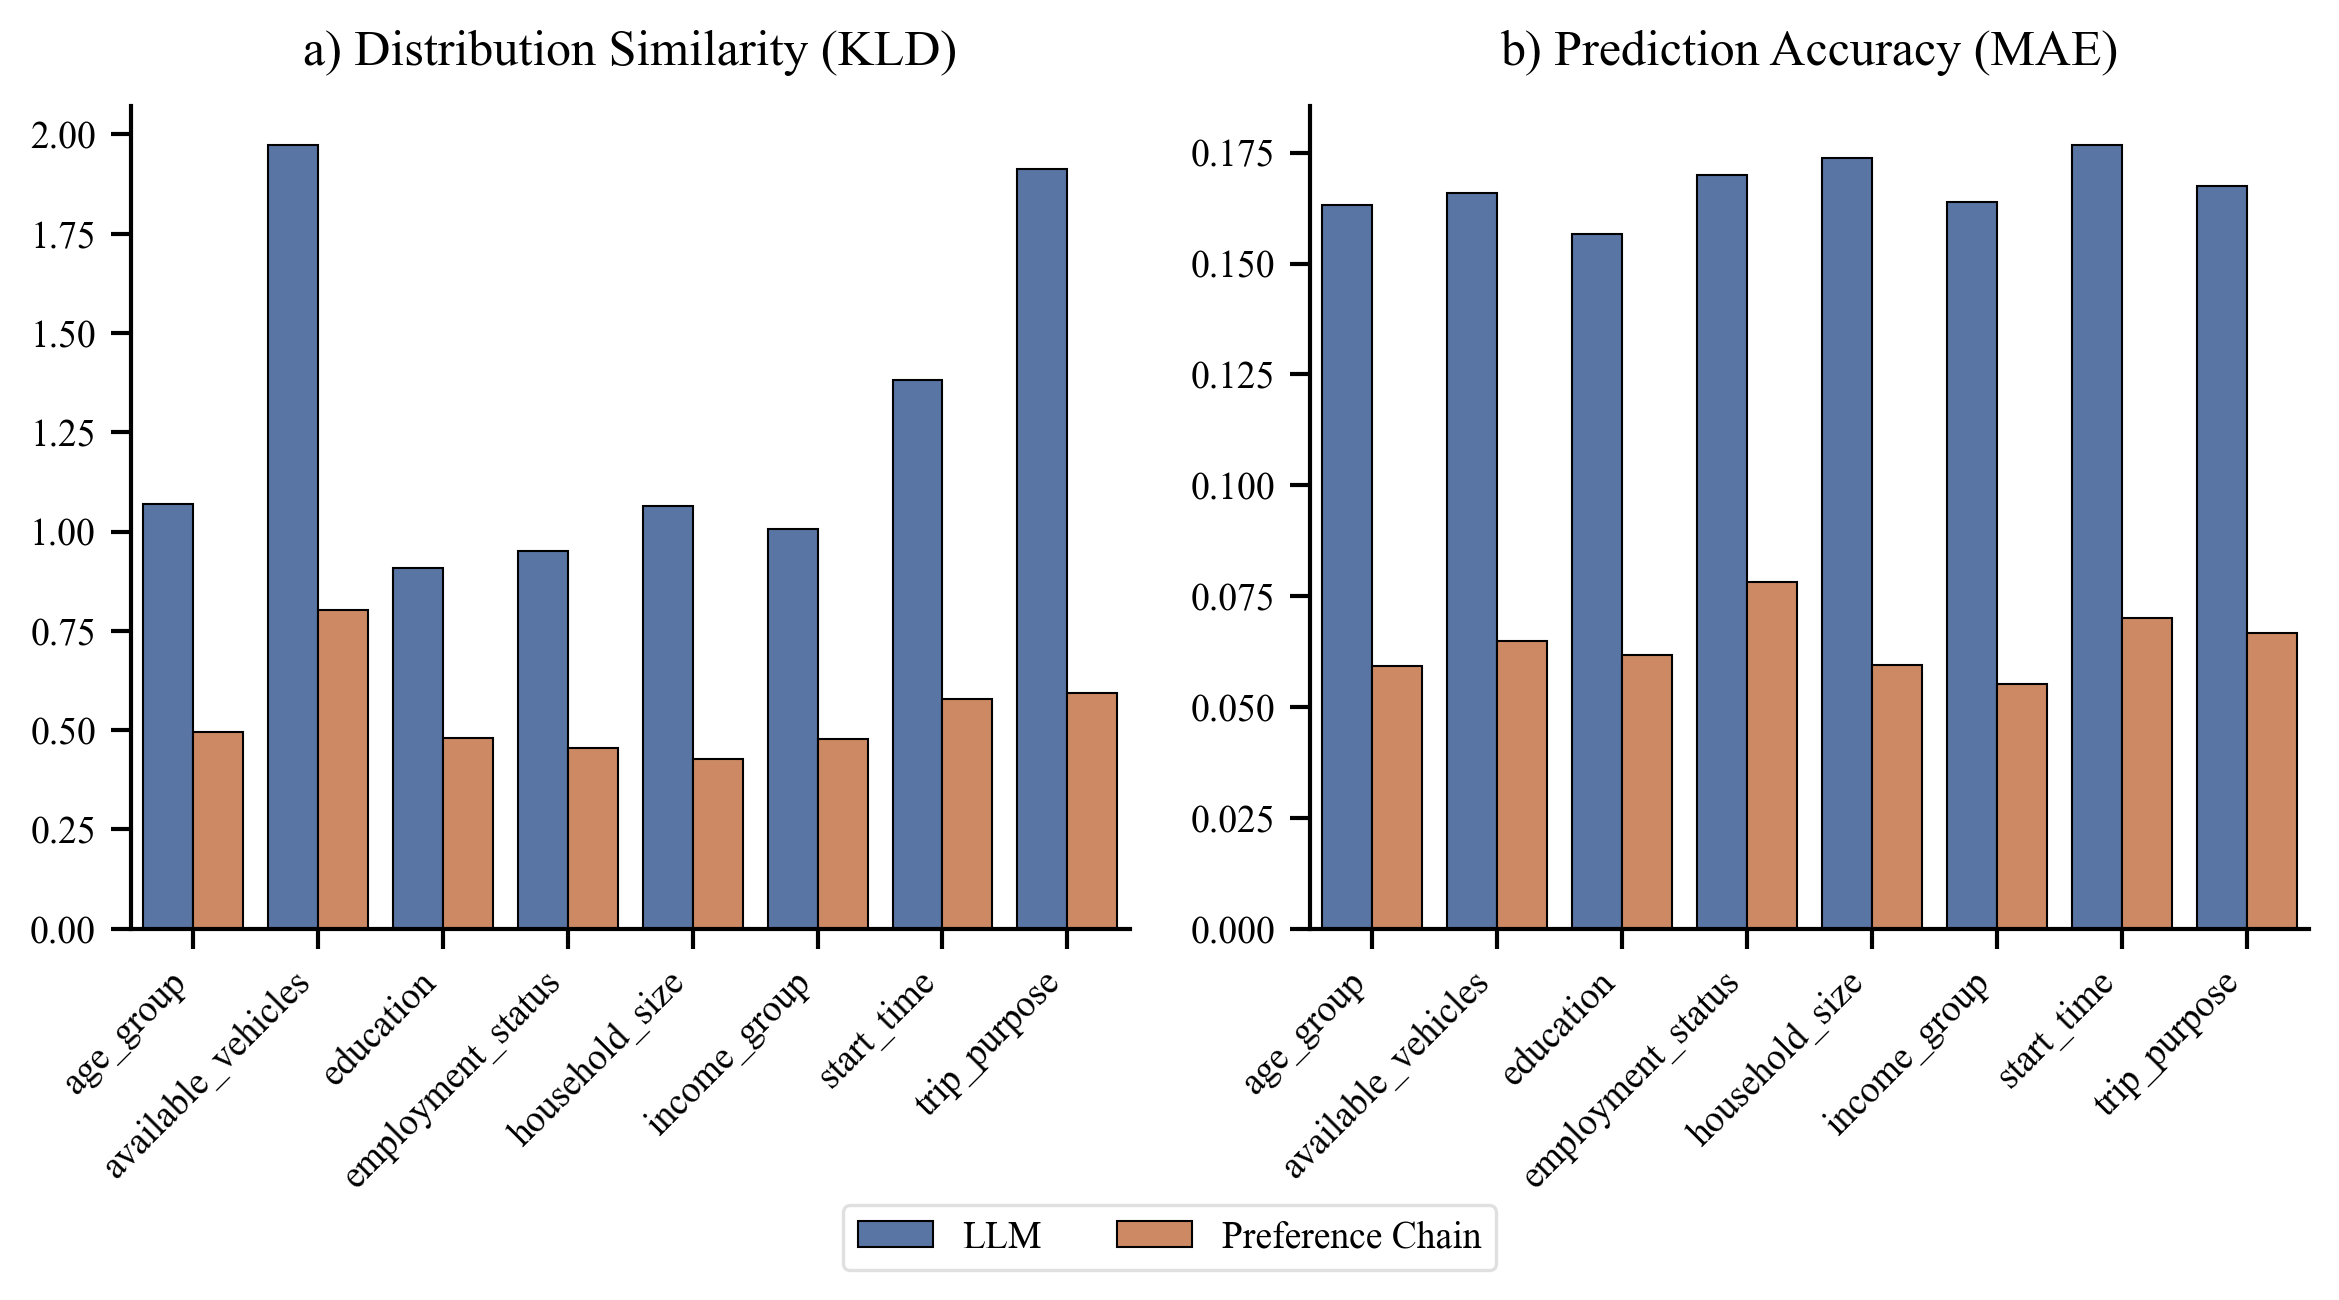

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set academic style parameters
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.autolayout': True
})

# Define color palette
palette = {"LLM": "#4C72B0", "Preference Chain": "#DD8452"}  # Blue and orange

# Define features and models
features_to_plot = [
    'age_group', 'income_group', 'employment_status',
    'household_size', 'available_vehicles', 'education',
    'trip_purpose', 'start_time'
]
models_to_compare = ['LLM', 'Preference Chain']

# Data cleaning (assuming df is your DataFrame)
df.columns = df.columns.str.strip()
df_filtered = df[df['model'].isin(models_to_compare)].copy()

# Ensure numeric types
df_filtered.loc[:, 'kl_divergence'] = pd.to_numeric(df_filtered['kl_divergence'], errors='coerce')
df_filtered.loc[:, 'mae'] = pd.to_numeric(df_filtered['mae'], errors='coerce')
df_filtered = df_filtered[df_filtered['feature'].isin(features_to_plot)]

if df_filtered.empty:
    print(f"Warning: No data found for models {models_to_compare} with specified features.")
else:
    # Aggregate data
    df_agg = df_filtered.groupby(['feature', 'model'], as_index=False).agg(
        kl_divergence_mean=('kl_divergence', 'mean'),
        mae_mean=('mae', 'mean')
    )

    if df_agg.empty:
        print("Warning: No data available for plotting after aggregation.")
    else:
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        # Plot 1: KL Divergence
        sns.barplot(data=df_agg, x='feature', y='kl_divergence_mean', hue='model',
                    palette=palette, ax=ax1, edgecolor='black', linewidth=0.5)
        
        # Formatting KL Divergence plot
        ax1.set_title('a) Distribution Similarity (KLD)', pad=10)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.legend_.remove()  # Remove individual legend
        
        # Remove spines
        for spine in ['top', 'right']:
            ax1.spines[spine].set_visible(False)
        
        # Plot 2: MAE
        sns.barplot(data=df_agg, x='feature', y='mae_mean', hue='model',
                    palette=palette, ax=ax2, edgecolor='black', linewidth=0.5)
        
        # Formatting MAE plot
        ax2.set_title('b) Prediction Accuracy (MAE)', pad=10)
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.legend_.remove()  # Remove individual legend
        
        # Remove spines
        for spine in ['top', 'right']:
            ax2.spines[spine].set_visible(False)
        
        # Create a single legend below both plots
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', 
                  bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True, framealpha=0.6)
        
        # Adjust layout to make room for the bottom legend
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)  # Adjust this value as needed
        plt.show()

# Mobility Agent vs ML models

In [20]:
import pandas as pd
from tqdm import tqdm
from baseline.train import train_baseline_model
from baseline.eval import cal_group_kl_divergence
import os

def get_mobility_agent_result(sample_list,result_folder= "models/mobility_agent",model_name="mobility_agent"):
    eval_list = []
    for num_samples in sample_list:
        result_file = os.path.join(result_folder,f"mobility_agent_{num_samples}.csv")
        result_df = pd.read_csv(result_file)
        primary_mode_list = ['walking', 'biking', 'auto_passenger', 'public_transit','private_auto', 'on_demand_auto','other_travel_mode']
        duration_minutes_list = ['0-10','10-20', '20-30', '30-40', '40-50', '50-60']
        # Filter the dataframe with valid output
        result_df = result_df[result_df['predicted_mode'].isin(primary_mode_list)]
        result_df = result_df[result_df['predicted_duration'].isin(duration_minutes_list)]
        kl_df, overall_kl, overall_mae = cal_group_kl_divergence(result_df=result_df)
        eval_list.append({
            "model": model_name,
            "num_samples": num_samples,
            "overall_kl": overall_kl,
            "overall_mae": overall_mae
        })
    return eval_list

# Initialize the list with mobility agent results
l1 = [i*10 for i in range(11)]
l2 = [i*100 for i in range(2,11)]
all_samples = l1 + l2

# eval_list1 = get_mobility_agent_result(all_samples,result_folder= "models/mobility_agent",model_name="Preference Chain1")
# eval_list2 = get_mobility_agent_result(all_samples,result_folder= "models/mobility_agent_gpt3",model_name="Preference Chain2")

# eval_list = eval_list1 + eval_list2

eval_list = get_mobility_agent_result(all_samples,result_folder= "models/mobility_agent",model_name="Preference Chain")

In [21]:
train_file = "data/reference/replica-cambridge_trips.csv"
eval_file = 'data/eval/replica-cambridge_trips_eval.csv'
model_keys = ["RF", "XGB", "MLP"]
sample_model_pairs = [(s, m, train_file, eval_file) for s in all_samples if s > 0 for m in model_keys]

from joblib import Parallel, delayed

# This will automatically handle nested parallelism cases
ml_results = Parallel(n_jobs=-1, backend="loky", verbose=0)(
    delayed(train_baseline_model)(*args) 
    for args in tqdm(sample_model_pairs, total=len(sample_model_pairs))
)

  0%|          | 0/57 [00:00<?, ?it/s]

 49%|████▉     | 28/57 [00:04<00:05,  5.69it/s]

========Optimizing parameters (model=XGBoost num_samples=10) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 50, 'estimator__subsample': 0.9}
Best score: 7.1436
=======Training model (model=XGBoost num_samples=10) =======
=======Evaluating model  (model=XGBoost num_samples=10) =======
Overall average KL divergence: 4.9860
Overall mean absolute error: 0.1249
========Optimizing parameters (model=XGBoost num_samples=20) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Best score: 4.6977
=======Training model (model=XGBoost num_samples=20) =======
========Optimizing parameters (model=XGBoost num_samples=30) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 100, 'estimator__subsample

 74%|███████▎  | 42/57 [00:10<00:04,  3.23it/s]

=======Evaluating model  (model=RandomForest num_samples=70) =======
Overall average KL divergence: 2.9114
Overall mean absolute error: 0.1017
========Optimizing parameters (model=XGBoost num_samples=70) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 10, 'estimator__subsample': 0.9}
Best score: 1.5107
=======Training model (model=XGBoost num_samples=70) =======
=======Evaluating model  (model=XGBoost num_samples=70) =======
Overall average KL divergence: 3.3757
Overall mean absolute error: 0.1072
========Optimizing parameters (model=XGBoost num_samples=80) ========
Best parameters: {'estimator__gamma': 0.1, 'estimator__learning_rate': 1e-05, 'estimator__max_depth': None, 'estimator__n_estimators': 50, 'estimator__subsample': 0.9}
Best score: 1.3907
=======Training model (model=XGBoost num_samples=80) =======
=======Evaluating model  (model=XGBoost num_samples=80) =======
Overall average KL di

100%|██████████| 57/57 [00:19<00:00,  2.86it/s]

=======Evaluating model  (model=MultilayerPerceptron num_samples=70) =======
Overall average KL divergence: 1.4509
Overall mean absolute error: 0.0703
=======Evaluating model  (model=XGBoost num_samples=200) =======
Overall average KL divergence: 2.6505
Overall mean absolute error: 0.0976
========Optimizing parameters (model=MultilayerPerceptron num_samples=80) ========
Best parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (128, 128)}
Best score: 0.0024
=======Training model (model=MultilayerPerceptron num_samples=80) =======


=======Evaluating model  (model=MultilayerPerceptron num_samples=80) =======
Overall average KL divergence: 0.9660
Overall mean absolute error: 0.0774
========Optimizing parameters (model=XGBoost num_samples=300) ========
Best parameters: {'estimator__gamma': 0, 'estimator__learning_rate': 0.001, 'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'estimator__subsample': 0.9}
Best score: 0.3040
=======Training model (model=XGBoost num_samples=300) =======
=======Evaluating model  (model=XGBoost num_samples=300) =======
Overall average KL divergence: 1.7357
Overall mean absolute error: 0.0862
========Optimizing parameters (model=RandomForest num_samples=300) ========
Best parameters: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
Best score: 0.0002
=======Training model (model=RandomForest num_samples=300) =======
=======Evaluating model  (model=RandomForest num_samples=300) =======
Overall aver

In [22]:
# Add non-None results to the list
result_list = eval_list + [r for r in ml_results if r is not None]
# Convert to DataFrame and save
result_df = pd.DataFrame(result_list)
result_df.to_csv("models/scores.csv", index=False)
print(f"Results saved to models/scores.csv")
result_df.head()

Results saved to models/scores.csv


,model,num_samples,overall_kl,overall_mae
0,Preference Chain,0,1.249948,0.185377
1,Preference Chain,10,0.709912,0.123127
2,Preference Chain,20,0.670283,0.106373
3,Preference Chain,30,0.569380,0.092031
4,Preference Chain,40,0.596527,0.107043


/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_10594/3208659105.py:109: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, linestyle=':', alpha=0.7)


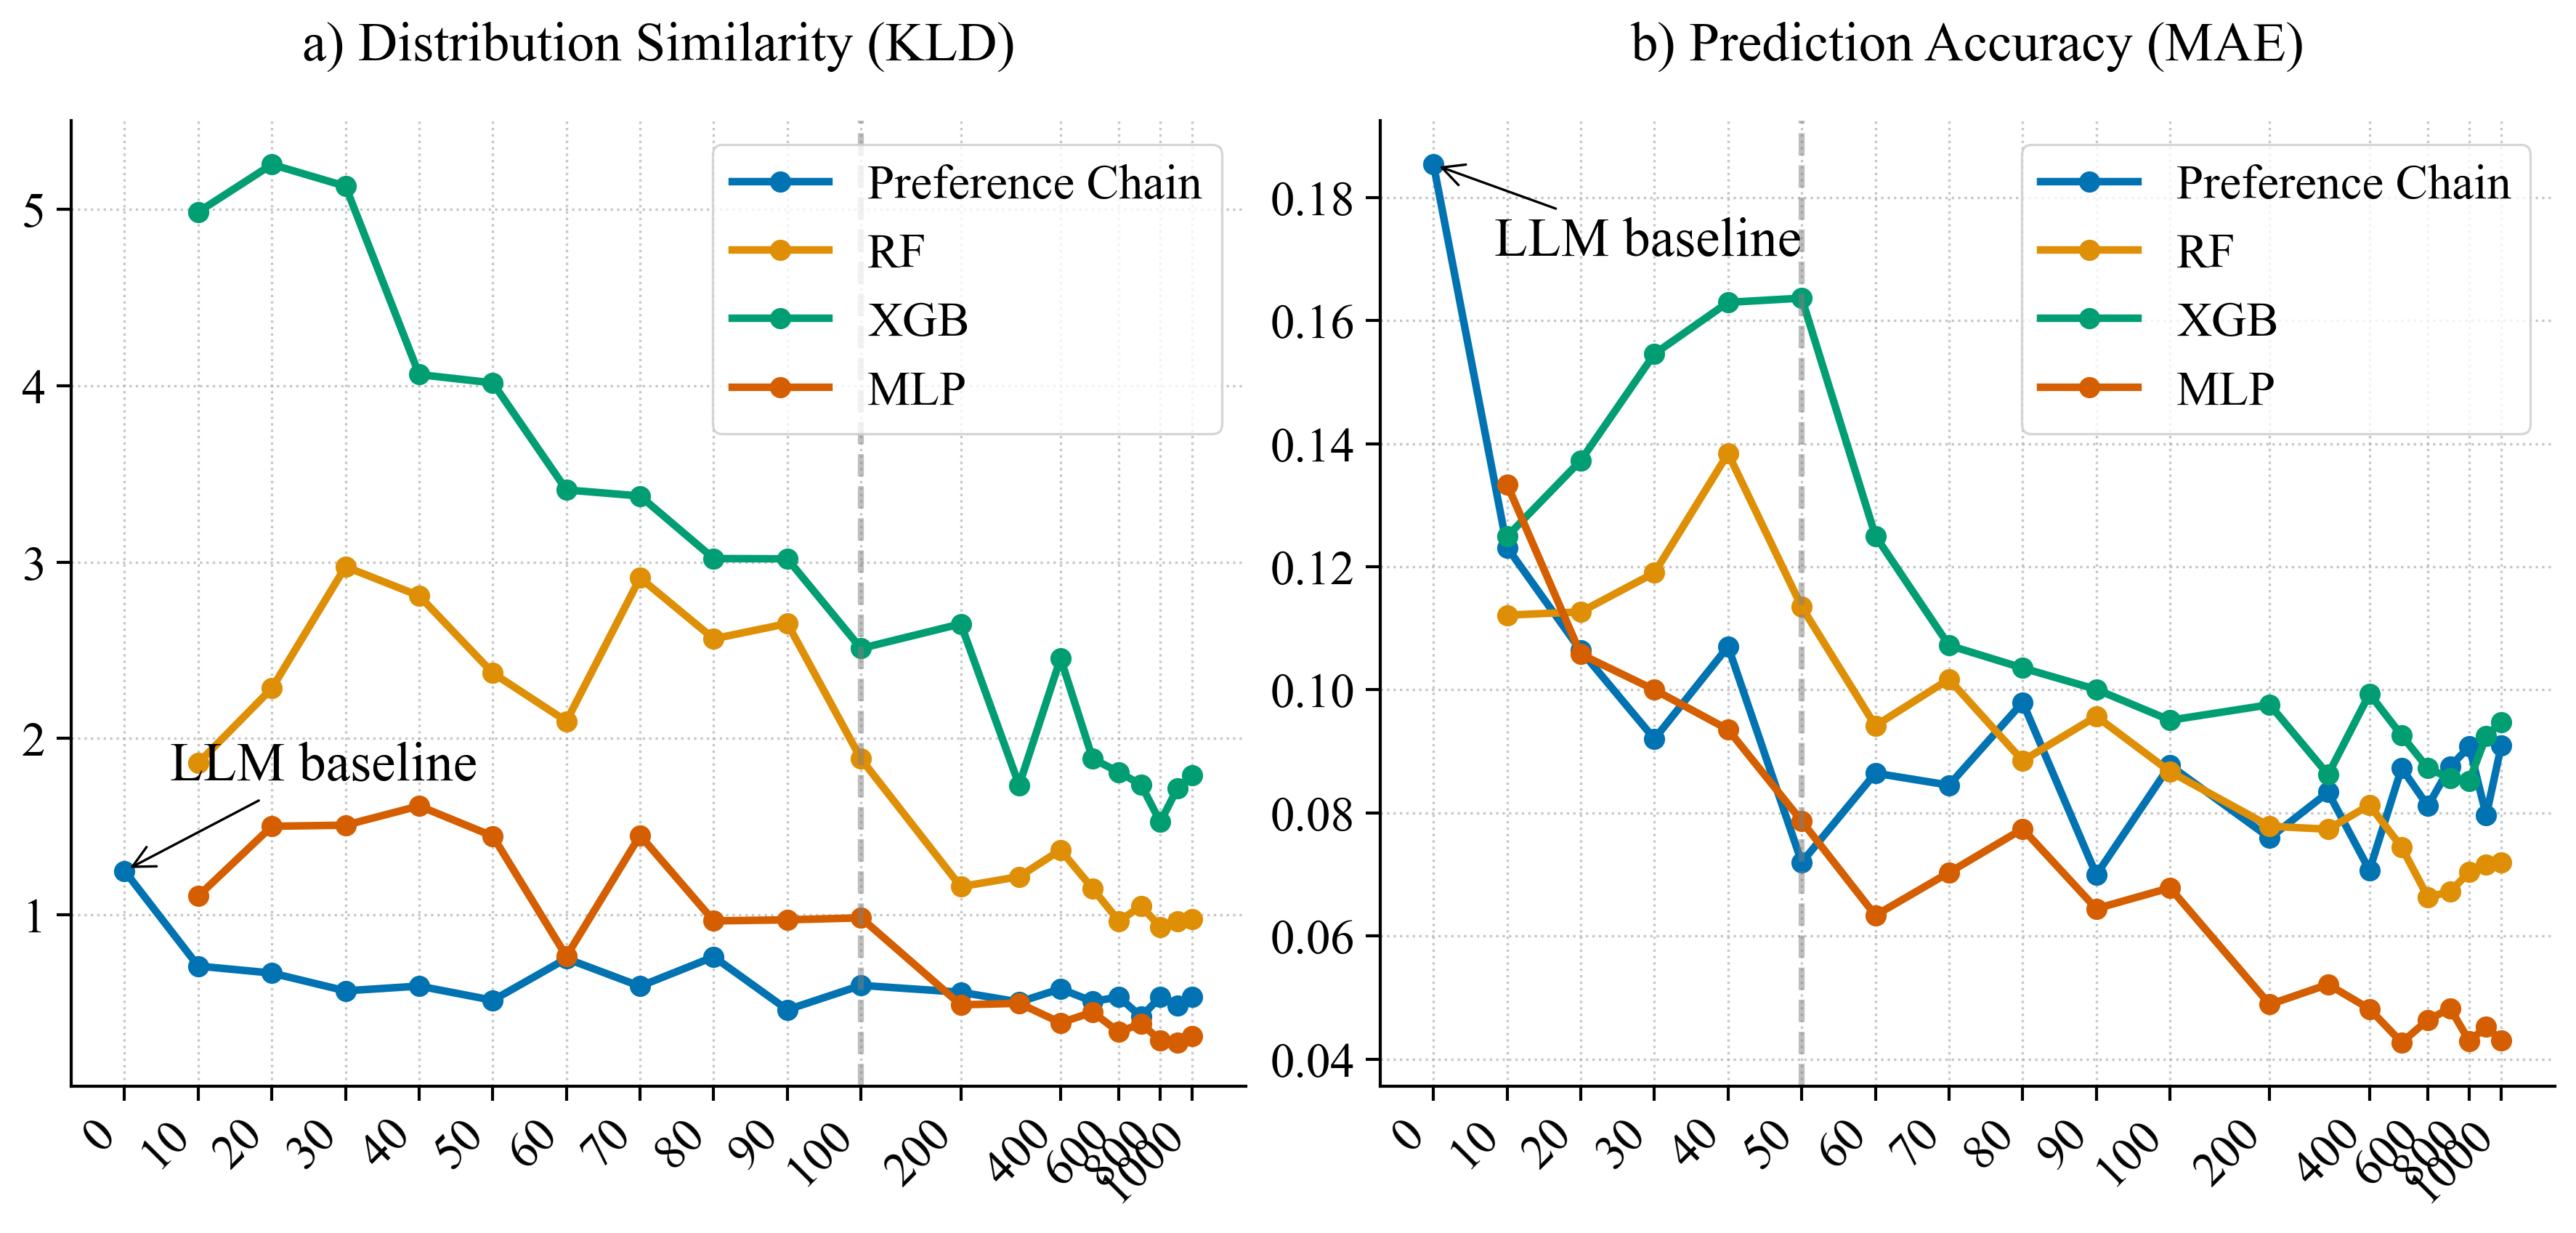

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plot_df =pd.read_csv("models/scores.csv")
# Set the style for the plots
# plt.style.use('white')
# sns.set_context("notebook", font_scale=1.2)
sns.set_context("paper", font_scale=1.4) 

fontsize = 16
line_kws = {'linewidth': 2.5, 'marker': 'o', 'markersize': 6}

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6),dpi=300)

# Get unique models and create a color palette
models = plot_df['model'].unique()
palette = sns.color_palette("colorblind", len(models))
model_color = dict(zip(models, palette))

# Get the x values we want to plot
sample_values = sorted(plot_df['num_samples'].unique())
tick_samples = [i*10 for i in range(11)] + [i*200 for i in range(1,6)]

# Plot KL divergence in the first subplot
ax = axes[0]
for model in models:
    # Filter data for this model
    model_df = plot_df[plot_df['model'] == model].sort_values('num_samples')
    ax.plot(model_df['num_samples'], model_df['overall_kl'], 
            label=f"{model}",color=model_color[model],**line_kws)

# Set up x-axis scale to give more space to 0-100 range
ax.set_xscale('symlog', linthresh=100, linscale=2)  # Linear scale until 100, then logarithmic
ax.set_xticks(tick_samples)
ax.set_xticklabels([str(x) for x in tick_samples], rotation=45, ha='right')

# Add vertical line at transition point
ax.axvline(x=100, color='gray', linestyle='--', alpha=0.5, linewidth=2)

# Add annotation for LLM without reference data at x=0
zero_data = plot_df[plot_df['num_samples'] == 0]
if not zero_data.empty:
    # Find the y-value at x=0 for annotation
    y_value = zero_data['overall_kl'].values[0]
    # Add annotation with an arrow
    ax.annotate('LLM baseline', 
                xy=(0, y_value), 
                xytext=(15, 30),  # Offset text position
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->'), 
                fontsize=fontsize+2)
    
ax.set_xlabel('', fontsize=fontsize, labelpad=10)
ax.set_ylabel('', fontsize=fontsize, labelpad=10)
ax.set_title('a) Distribution Similarity (KLD)', fontsize=fontsize+2, pad=20)

ax.legend(loc='upper right', fontsize=fontsize)
# ax.grid(True, linestyle='--', alpha=0.7)

# Plot MAE in the second subplot
# Plot MAE in the second subplot
ax = axes[1]
for model in models:
    # Filter data for this model
    model_df = plot_df[plot_df['model'] == model].sort_values('num_samples')
    ax.plot(model_df['num_samples'], model_df['overall_mae'], 
            label=f"{model}",color=model_color[model],**line_kws)

# Set up x-axis scale to give more space to 0-100 range
ax.set_xscale('symlog', linthresh=100, linscale=2)  # Linear scale until 100, then logarithmic
ax.set_xticks(tick_samples)
ax.set_xticklabels([str(x) for x in tick_samples], rotation=45, ha='right')

# Add vertical line at transition point
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, linewidth=2)

# Add annotation for LLM without reference data at x=0
zero_data = plot_df[plot_df['num_samples'] == 0]
if not zero_data.empty:
    # Find the y-value at x=0 for annotation
    y_value = zero_data['overall_mae'].values[0]
    # Add annotation with an arrow
    ax.annotate('LLM baseline', 
                xy=(0, y_value), 
                xytext=(20, -30),  # Offset text position
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->'), 
                fontsize=fontsize+2)

ax.set_xlabel('', fontsize=fontsize, labelpad=10)
ax.set_ylabel('', fontsize=fontsize, labelpad=10)
ax.set_title('b) Prediction Accuracy (MAE)', fontsize=fontsize+2, pad=20)
ax.legend(loc='upper right', fontsize=fontsize)
# ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', fontsize=fontsize)
# ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and add title
plt.tight_layout()
# plt.suptitle('Model Performance Across Different Sample Sizes (Lower is Better)', 
#             fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)

# Final adjustments
for ax in axes:
    ax.grid(False, linestyle=':', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Show the plot
plt.show()